In [ ]:
# !pip install pyforest
# !pip install pycaret
# !pip install fastai

In [ ]:
import pyforest
import pycaret

## Classification using Fast ai

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
import itertools
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

In [ ]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [ ]:
IMG_PATH = '/content/drive/My Drive/Classification Images'
BS = 16 
TEST_FOLDER = '/content/drive/My Drive/Classification Images/test/'

In [ ]:
tfms = get_transforms()
data = (ImageDataBunch.from_folder(IMG_PATH, ds_tfms=tfms, size=224, valid_pct=0.2, bs=BS).\
       normalize(imagenet_stats))

In [ ]:
# number of classes
data.c, data.classes

(3, ['foggy image', 'hazy image', 'sunny image'])

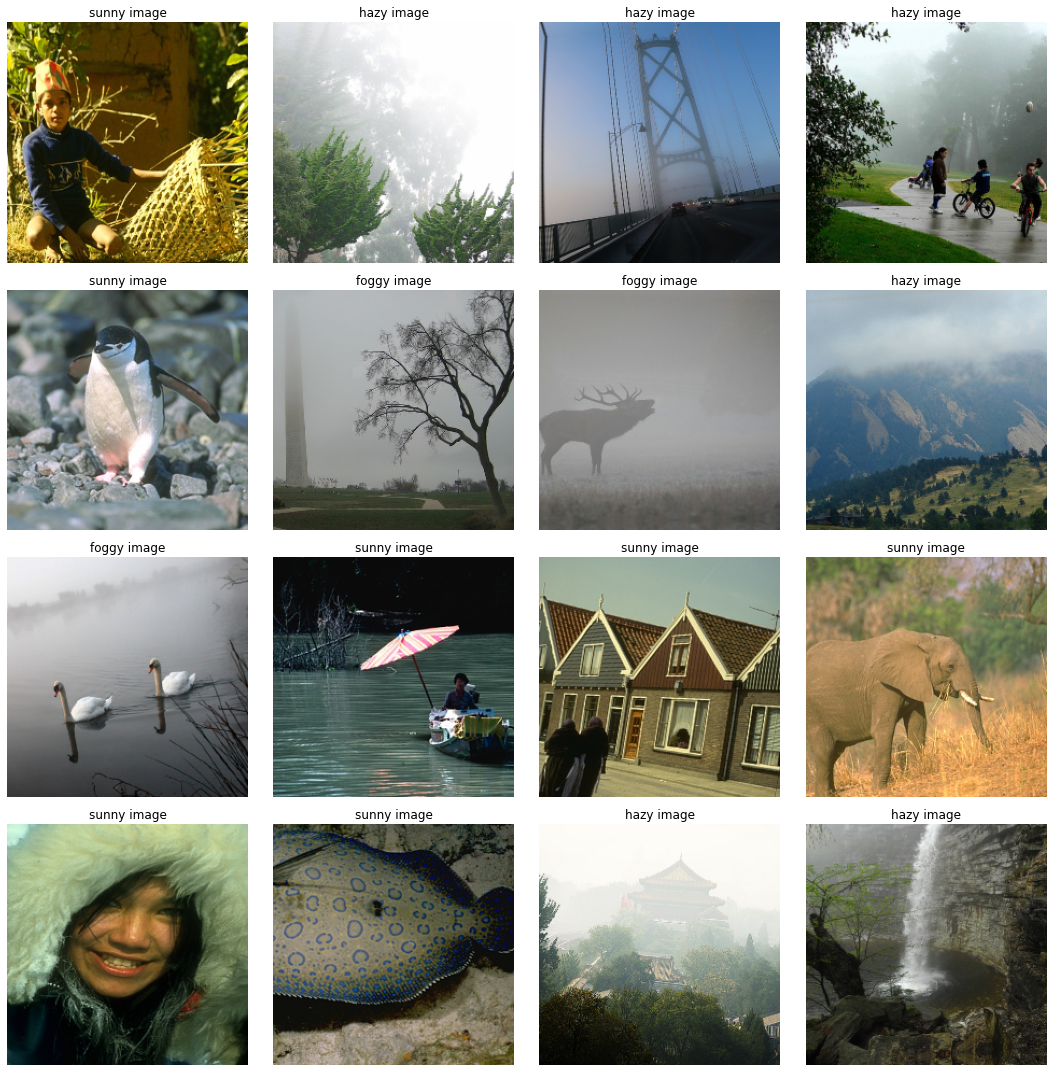

In [ ]:
data.show_batch(rows=15, figsize=(15,15))

In [ ]:
#mixup is used for additional Augumentation
learn = cnn_learner(data, models.resnet50, metrics=accuracy).mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-04
Min loss divided by 10: 4.79E-03


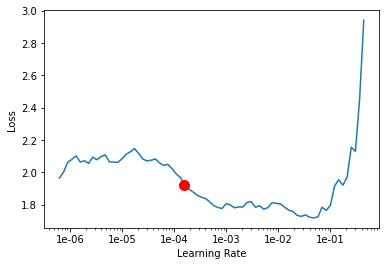

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1.5e-4,4.8e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.449925,4.044434,0.648241,00:25
1,1.133512,0.526079,0.839196,00:26
2,0.929694,0.590160,0.783920,00:25
3,0.780807,0.399303,0.879397,00:26
4,0.715429,0.362663,0.869347,00:27


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 5.25E-06


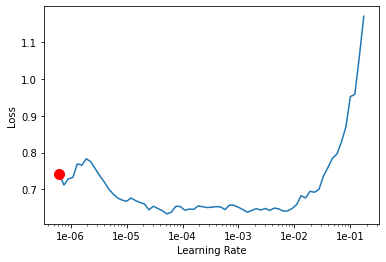

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(6e-7,5e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.645398,0.404891,0.859297,00:24
1,0.649397,0.349803,0.874372,00:24
2,0.669243,0.355915,0.874372,00:24
3,0.674884,0.353348,0.869347,00:24


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 5.75E-07


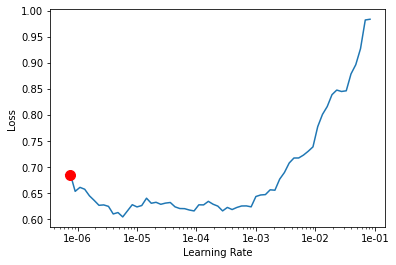

In [ ]:
learn.freeze_to(-10)
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(3, max_lr=slice(7.5e-7,5.7e-7))

epoch,train_loss,valid_loss,accuracy,time
0,0.659980,0.322415,0.904523,00:26
1,0.628880,0.391032,0.874372,00:26
2,0.672606,0.363388,0.874372,00:26


In [ ]:
learn.save('/content/drive/My Drive/Classification Images/learn_stage1')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

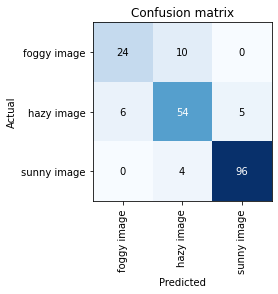

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
learn.load('/content/drive/My Drive/Classification Images/learn_stage1')

Learner(data=ImageDataBunch;

Train: LabelList (800 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
foggy image,foggy image,foggy image,foggy image,foggy image
Path: /content/drive/My Drive/Classification Images;

Valid: LabelList (199 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
hazy image,sunny image,sunny image,sunny image,hazy image
Path: /content/drive/My Drive/Classification Images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 

In [ ]:
TARGET = data.classes
target_df = []
for t in TARGET:
  for i in os.walk(TEST_FOLDER + t):
    images = i[2]
    img_path = [i[0]]*len(images)
    df1 = pd.DataFrame({'image_path':img_path, 'image_name':images})
    target_df.append(df1)

In [ ]:
test = pd.concat(target_df)
test['weather'] = test['image_path'].apply(lambda x: x.split('/')[-1])
test['image_path2'] = test['image_path'] +'/' + test['image_name']
test.reset_index(drop=True, inplace=True)

In [ ]:
predict = []
for i in tqdm_notebook(range(test.shape[0])):
  file_path = test.loc[i,'image_path2']
  img=open_image(file_path)
  pred = data.classes[np.argmax(learn.predict(img)[-1]).item()]
  predict.append(pred)


In [ ]:
test['prediction'] = predict
test['actual'] = test['weather'].apply(lambda x: data.classes.index(x))
test['prediction_array'] = test['prediction'].apply(lambda x: data.classes.index(x))

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

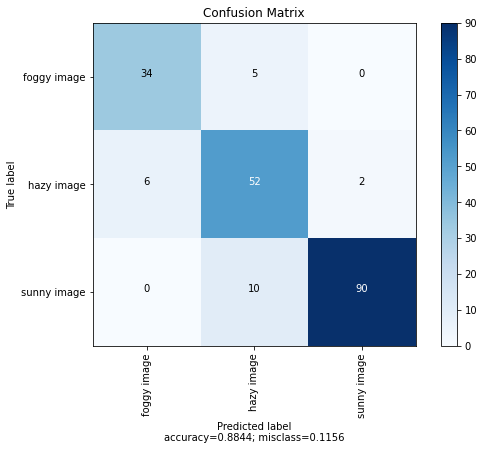

In [ ]:
cm = confusion_matrix(test['actual'], test['prediction_array'])
plot_confusion_matrix(cm , 
                      normalize    = False,
                      target_names = data.classes,
                      title        = "Confusion Matrix")

In [ ]:
def function_to_predict(learn, test):
  predict = []
  for i in tqdm_notebook(range(test.shape[0])):
    file_path = test.loc[i,'image_path2']
    img=open_image(file_path)
    pred = data.classes[np.argmax(learn.predict(img)[-1]).item()]
    predict.append(pred)
  return predict


FAST AI Ensemble method

In [ ]:
results = {}
for model in [models.vgg19_bn, models.densenet121, models.resnet50, models.resnet101]:
  learn = cnn_learner(data, model, metrics=accuracy).mixup()
  learn.unfreeze()
  learn.fit_one_cycle(5, max_lr=slice(1.5e-4,4.8e-3))
  learn.freeze()
  learn.fit_one_cycle(4, max_lr=slice(6e-7,5e-6))
  learn.freeze_to(-10)
  learn.fit_one_cycle(3, max_lr=slice(7.5e-7,5.7e-7))
  results[model] = function_to_predict(learn,test)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


epoch,train_loss,valid_loss,accuracy,time
0,1.364465,1.435060,0.703518,03:34
1,1.148237,0.876677,0.723618,00:35
2,0.977801,0.464635,0.844221,00:35
3,0.801704,0.533891,0.783920,00:35
4,0.698198,0.446814,0.849246,00:35


epoch,train_loss,valid_loss,accuracy,time
0,0.679645,0.438277,0.869347,00:28
1,0.669103,0.437347,0.879397,00:28
2,0.672173,0.453115,0.854271,00:28
3,0.682470,0.437577,0.869347,00:28


epoch,train_loss,valid_loss,accuracy,time
0,0.647513,0.443599,0.864322,00:35
1,0.666148,0.426914,0.864322,00:36
2,0.672814,0.440193,0.869347,00:35


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


epoch,train_loss,valid_loss,accuracy,time
0,1.408035,0.691273,0.743719,00:33
1,1.131650,0.426495,0.793970,00:31
2,0.916696,0.692275,0.773869,00:30
3,0.762873,0.376265,0.879397,00:31
4,0.704549,0.450539,0.889447,00:31


epoch,train_loss,valid_loss,accuracy,time
0,0.673814,0.426621,0.884422,00:29
1,0.675389,0.424333,0.894472,00:28
2,0.634729,0.445246,0.879397,00:27
3,0.639872,0.390201,0.884422,00:27


epoch,train_loss,valid_loss,accuracy,time
0,0.677331,0.375502,0.889447,00:30
1,0.666032,0.374088,0.894472,00:30
2,0.655015,0.401039,0.889447,00:30


epoch,train_loss,valid_loss,accuracy,time
0,1.477292,1.887254,0.748744,00:28
1,1.117834,0.491670,0.773869,00:28
2,0.915491,0.395550,0.854271,00:28
3,0.756857,0.334380,0.854271,00:27
4,0.659361,0.325851,0.854271,00:27


epoch,train_loss,valid_loss,accuracy,time
0,0.600012,0.319657,0.874372,00:25
1,0.582667,0.321160,0.874372,00:25
2,0.584747,0.317088,0.869347,00:25
3,0.606125,0.314709,0.874372,00:25


epoch,train_loss,valid_loss,accuracy,time
0,0.583379,0.316353,0.869347,00:27
1,0.555519,0.321002,0.879397,00:28
2,0.578872,0.321468,0.874372,00:28


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


epoch,train_loss,valid_loss,accuracy,time
0,1.646014,5.885973,0.623116,00:38
1,1.167096,0.868146,0.788945,00:38
2,0.903565,0.431236,0.814070,00:38
3,0.739745,0.418316,0.798995,00:38
4,0.655356,0.344088,0.864322,00:38


epoch,train_loss,valid_loss,accuracy,time
0,0.580321,0.354764,0.854271,00:30
1,0.616429,0.345897,0.859297,00:31
2,0.572340,0.351042,0.859297,00:30
3,0.569524,0.340910,0.864322,00:30


epoch,train_loss,valid_loss,accuracy,time
0,0.613570,0.351695,0.854271,00:37
1,0.608100,0.346629,0.864322,00:37
2,0.587592,0.352465,0.849246,00:37


In [ ]:
results_df = pd.DataFrame(results, columns=None)
results_df.columns = [0,1,2,3]
for c in results_df.columns:
  results_df[c] = results_df[c].apply(lambda x: data.classes.index(x))

In [ ]:
results_df['ensemble_pred'] = results_df.mode(axis=1).iloc[:,0]

test['ensemble_pred'] = results_df['ensemble_pred']

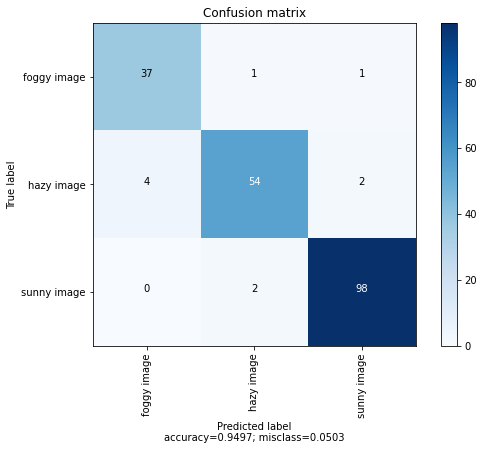

In [ ]:
cm = confusion_matrix(test['actual'], test['ensemble_pred'])
plot_confusion_matrix(cm, target_names=TARGET, normalize=False)

Ensemble model produced better results comparatively to tune the model further, may be find the appropriate learning rate for each of the model and adjust the epochs accordingly, script is not in organised a wayy may be create methods and to generalise the script to predict on the incoming images, tried to generalise the predict function, but still it uses certain global parameters like data.classes which needs to be passed as parameter